In [1]:
from ThermoNet.Development.ThermoNetTorch import ThermoNet, ThermoLossFunc, ThermoDataset
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop
from SGTEHandler.Development.SGTEHandler import SGTEHandler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def epoch(net: ThermoNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, (temp, g, s, h, c) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)

        # Forward pass
        gibbs_energy, entropy, enthalpy, heat_cap = net(temp, temp, temp, temp)

        scale = 10000
        gibbs_energy, entropy, enthalpy, heat_cap = gibbs_energy/scale, entropy/scale, enthalpy/scale, heat_cap/scale
        g, s, h, c = g/scale, s/scale, h/scale, c/scale

        # Get the loss
        loss = loss_func(gibbs_energy.float(), g.float(), entropy.float(), s.float(), enthalpy.float(), h.float(),
                         heat_cap.float(), c.float())

        # Backward pass
        net.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 100)
        optimizer.step()
        epoch_losses[i] = loss

    mean_epoch_loss = epoch_losses.mean()
    print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [3]:
def train(net, element, phase):
    # Hyperparameters
    n_epochs = 500
    lr = 0.01
    batch_size = 16

    # Data
    dataset = ThermoDataset(element, phase)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = Rprop(net.parameters(), lr=lr)
    loss_func = ThermoLossFunc()

    losses = []

    for i in range(n_epochs):
        print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss)

In [11]:
def graphic_evaluation(net, element, phase):
    start_temp = 200
    end_temp = 2000
    temp_range = torch.tensor(list(range(start_temp, end_temp)), dtype=torch.float64).unsqueeze(-1)

    # Get true data
    sgte_handler = SGTEHandler(element)
    sgte_handler.evaluate_equations(start_temp, end_temp, 1e5, plot=False, phases=phase, entropy=True, enthalpy=True,
                                    heat_capacity=True)
    data = sgte_handler.equation_result_data

    # Get values
    temp = torch.tensor(data['Temperature'], dtype=torch.float64)
    gibbs = torch.tensor(data.iloc[:, 1])
    entropy = torch.tensor(data.iloc[:, 2])
    enthalpy = torch.tensor(data.iloc[:, 3])
    heat_cap = torch.tensor(data.iloc[:, 4])
    
    if start_temp < temp.min():
        temp_range = torch.tensor(list(range(int(temp.min()), end_temp)), dtype=torch.float64).unsqueeze(-1)

    gibbs_pred, entropy_pred, enthalpy_pred, heat_cap_pred = net(temp_range, temp_range, temp_range, temp_range)

    gibbs_pred = gibbs_pred.detach()
    entropy_pred = entropy_pred.detach()
    enthalpy_pred = enthalpy_pred.detach()
    heat_cap_pred = heat_cap_pred.detach()
    
    plt.figure()
    plt.plot(temp, gibbs)
    plt.grid()
    plt.scatter(temp_range, gibbs_pred, s=0.3, c='red')

    plt.figure()
    plt.plot(temp, entropy)
    plt.grid()
    plt.scatter(temp_range, entropy_pred, s=0.3, c='red')

    plt.figure()
    plt.plot(temp, enthalpy)
    plt.grid()
    plt.scatter(temp_range, enthalpy_pred, s=0.3, c='red')

    plt.figure()
    plt.plot(temp, heat_cap)
    plt.grid()
    plt.scatter(temp_range, heat_cap_pred, s=0.3, c='red')
    plt.show()

In [5]:
net = ThermoNet()

element = 'Fe'
phase = ['BCC_A2']
train(net, element, phase)

Fe successfully selected!

-----
Epoch 0:

Mean epoch loss:  1.7959040408936617
-----
Epoch 1:

Mean epoch loss:  0.46882998859770947
-----
Epoch 2:

Mean epoch loss:  0.4467008963366535
-----
Epoch 3:

Mean epoch loss:  0.4329216196158222
-----
Epoch 4:

Mean epoch loss:  0.42424705735990936
-----
Epoch 5:

Mean epoch loss:  0.42176039725820597
-----
Epoch 6:

Mean epoch loss:  0.4201642060391257
-----
Epoch 7:

Mean epoch loss:  0.41226384405777833
-----
Epoch 8:

Mean epoch loss:  0.40270093083381653
-----
Epoch 9:

Mean epoch loss:  0.39948072695286474
-----
Epoch 10:

Mean epoch loss:  0.39686224393755476
-----
Epoch 11:

Mean epoch loss:  0.3912380387849897
-----
Epoch 12:

Mean epoch loss:  0.3854710810652403
-----
Epoch 13:

Mean epoch loss:  0.3682321978506641
-----
Epoch 14:

Mean epoch loss:  0.3606860646020586
-----
Epoch 15:

Mean epoch loss:  0.35414465203463474
-----
Epoch 16:

Mean epoch loss:  0.344129269646707
-----
Epoch 17:

Mean epoch loss:  0.3349265183243796
----

Mean epoch loss:  0.2101589842377422
-----
Epoch 150:

Mean epoch loss:  0.20973828978070588
-----
Epoch 151:

Mean epoch loss:  0.20874494439530594
-----
Epoch 152:

Mean epoch loss:  0.20913630584690057
-----
Epoch 153:

Mean epoch loss:  0.20880605642483613
-----
Epoch 154:

Mean epoch loss:  0.20880424837085687
-----
Epoch 155:

Mean epoch loss:  0.20859672017743655
-----
Epoch 156:

Mean epoch loss:  0.20863599420707918
-----
Epoch 157:

Mean epoch loss:  0.2088572406601683
-----
Epoch 158:

Mean epoch loss:  0.20827196120658767
-----
Epoch 159:

Mean epoch loss:  0.2087070146732241
-----
Epoch 160:

Mean epoch loss:  0.20851131145642182
-----
Epoch 161:

Mean epoch loss:  0.20777986679121713
-----
Epoch 162:

Mean epoch loss:  0.20764217045262595
-----
Epoch 163:

Mean epoch loss:  0.2080180714620608
-----
Epoch 164:

Mean epoch loss:  0.20769571519900706
-----
Epoch 165:

Mean epoch loss:  0.20754871009109177
-----
Epoch 166:

Mean epoch loss:  0.20764381640425353
-----
Epoch 16

Mean epoch loss:  0.18886868363228915
-----
Epoch 297:

Mean epoch loss:  0.18872415977660742
-----
Epoch 298:

Mean epoch loss:  0.18889353876916049
-----
Epoch 299:

Mean epoch loss:  0.1887978617554513
-----
Epoch 300:

Mean epoch loss:  0.1882041635635857
-----
Epoch 301:

Mean epoch loss:  0.1872826544480903
-----
Epoch 302:

Mean epoch loss:  0.18765351287672452
-----
Epoch 303:

Mean epoch loss:  0.18732878537935632
-----
Epoch 304:

Mean epoch loss:  0.18725015362289466
-----
Epoch 305:

Mean epoch loss:  0.1875130313439904
-----
Epoch 306:

Mean epoch loss:  0.1868534838763353
-----
Epoch 307:

Mean epoch loss:  0.1867660435839234
-----
Epoch 308:

Mean epoch loss:  0.18732320301443617
-----
Epoch 309:

Mean epoch loss:  0.18760722457805526
-----
Epoch 310:

Mean epoch loss:  0.18683157930864353
-----
Epoch 311:

Mean epoch loss:  0.18660816160317895
-----
Epoch 312:

Mean epoch loss:  0.18694652951209345
-----
Epoch 313:

Mean epoch loss:  0.18645153006660603
-----
Epoch 314:

Mean epoch loss:  0.1774635998723663
-----
Epoch 445:

Mean epoch loss:  0.17767395845083434
-----
Epoch 446:

Mean epoch loss:  0.17756522328497093
-----
Epoch 447:

Mean epoch loss:  0.17761853810782743
-----
Epoch 448:

Mean epoch loss:  0.17769050319618154
-----
Epoch 449:

Mean epoch loss:  0.17812077937839188
-----
Epoch 450:

Mean epoch loss:  0.17728903430087545
-----
Epoch 451:

Mean epoch loss:  0.17739431156176272
-----
Epoch 452:

Mean epoch loss:  0.17778282703083254
-----
Epoch 453:

Mean epoch loss:  0.17716872594623922
-----
Epoch 454:

Mean epoch loss:  0.17716731451382148
-----
Epoch 455:

Mean epoch loss:  0.1771570289524916
-----
Epoch 456:

Mean epoch loss:  0.17744972034592496
-----
Epoch 457:

Mean epoch loss:  0.1770771709836532
-----
Epoch 458:

Mean epoch loss:  0.17776278183560504
-----
Epoch 459:

Mean epoch loss:  0.17734181581535072
-----
Epoch 460:

Mean epoch loss:  0.1771478907805737
-----
Epoch 461:

Mean epoch loss:  0.177158541559616
-----
Epoch 462:

Fe successfully selected!



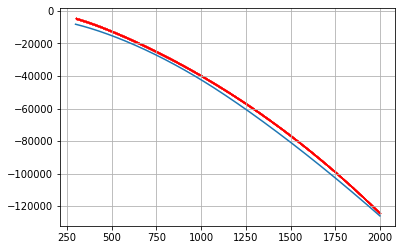

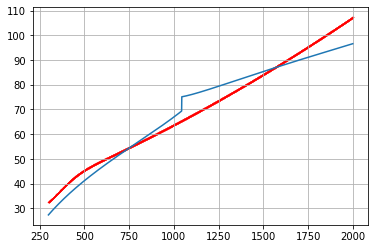

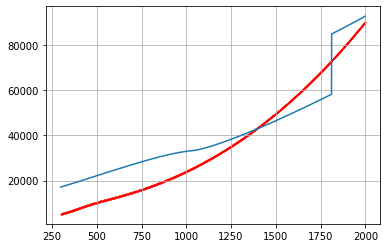

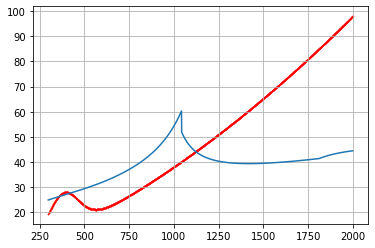

In [12]:
graphic_evaluation(net, element, phase)

In [8]:
torch.save(net, 'ThermoNet/Models/model_12_01_22_1535')